In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import wandb

from models.unet import UNet
from utils.checkpoint import save_checkpoint, load_checkpoint
from utils.datasets import OrigaDataset, load_origa
from utils.metrics import *
from utils.visualization import *

In [2]:
IMAGE_DIR = '../data/ORIGA/Images_Cropped'
MASK_DIR = '../data/ORIGA/Masks_Cropped'
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
BATCH_SIZE = 4
LEARNING_RATE = 1e-4
EPOCHS = 5
LAYERS = [32, 64, 128, 256]
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
PIN_MEMORY = True if DEVICE == 'cuda' else False
LOAD_MODEL = ''
USE_WANDB = False

CLASS_LABELS = {
    0: 'Background',
    1: 'Optic Disc',
    2: 'Optic Cup',
}

print(f'PyTorch version: {torch.__version__}')
print(f'Using device: {DEVICE}')

PyTorch version: 2.0.1+cu118
Using device: cuda


In [3]:
if USE_WANDB:
    wandb.login()

In [4]:
config = {
    'image_size': (IMAGE_HEIGHT, IMAGE_WIDTH),
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'epochs': EPOCHS,
    'dataset': 'ORIGA',
    'layers': LAYERS,
}

# Initialize Weights & Biases
if USE_WANDB:
    wandb.init(project='DP-Glaucoma', config=config)

Image shape: torch.Size([1, 3, 128, 128])
Mask shape: torch.Size([1, 128, 128])
Unique values and their counts in mask: {0: 5922, 1: 5486, 2: 4976}


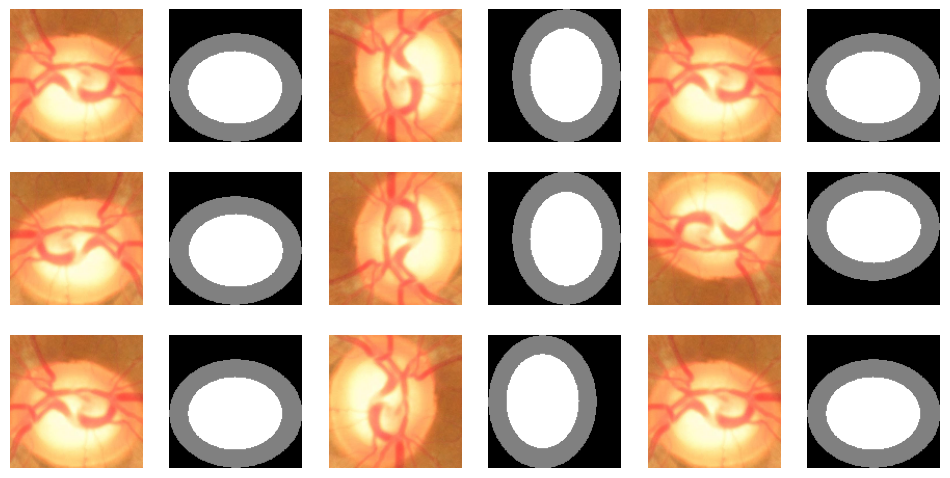

In [5]:
example_ds = OrigaDataset(IMAGE_DIR, MASK_DIR, os.listdir(IMAGE_DIR)[:1], A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),  # rotate by 0, 90, 180, or 270 degrees
    # A.Rotate(limit=30, p=0.33, border_mode=cv.BORDER_CONSTANT),
    # A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
    ToTensorV2(),
]))
example_loader = DataLoader(example_ds, batch_size=1, shuffle=True)

example_image, example_mask = next(iter(example_loader))
print(f'Image shape: {example_image.shape}')
print(f'Mask shape: {example_mask.shape}')

unique, counts = np.unique(example_mask, return_counts=True)
print(f'Unique values and their counts in mask: {dict(zip(unique, counts))}')

# Plot example augmented images and masks
fig, ax = plt.subplots(3, 6, figsize=(12, 6))
ax = ax.ravel()
for i in range(0, 3 * 6, 2):
    batch = next(iter(example_loader))
    images, masks = batch
    image, mask = images[0], masks[0]
    image = image.permute(1, 2, 0).numpy()
    mask = mask.numpy()
    ax[i].imshow(image)
    ax[i].axis('off')
    ax[i + 1].imshow(mask, cmap='gray')
    ax[i + 1].axis('off')
plt.show()

In [6]:
train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),
    A.Rotate(limit=30, p=0.25, border_mode=cv.BORDER_CONSTANT),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
    ToTensorV2()
])

train_ds, val_ds, test_ds = load_origa(
    IMAGE_DIR, MASK_DIR, train_transform, val_transform, val_transform,
    train_size=0.7, val_size=0.15, test_size=0.15,
    # train_size=0.01, val_size=0.01, test_size=0.98,
)

print(f'Train size: {len(train_ds)}')
print(f'Validation size: {len(val_ds)}')
print(f'Test size: {len(test_ds)}')

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

Train size: 454
Validation size: 98
Test size: 98


In [7]:
def train_one_epoch(model, criterion, optimizer, device, loader, scheduler=None):
    model.train()
    history = defaultdict(list)
    total = len(loader)
    loop = tqdm(loader, total=total, leave=True, desc='Training')
    mean_metrics = None

    # iterate once over all the batches in the training data loader
    for batch_idx, (images, masks) in enumerate(loop):
        # move data to device
        images = images.to(device=device)
        masks = masks.to(device=device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, masks.long())

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate metrics
        preds = torch.argmax(outputs, dim=1)
        metrics = get_performance_metrics(masks.cpu(), preds.cpu())

        # update training history
        history['loss'].append(loss.item())
        for k, v in metrics.items():
            history[k].append(v)

        # display average metrics at the end of the epoch
        last_batch = batch_idx == total - 1
        if last_batch:
            mean_metrics = {k: np.mean(v) for k, v in history.items()}
            loop.set_postfix(**mean_metrics)

    # learning rate scheduler
    if scheduler is not None:
        scheduler.step(mean_metrics['loss'])

    return mean_metrics


def validate_one_epoch(model, criterion, device, loader):
    model.eval()
    history = defaultdict(list)
    total = len(loader)
    loop = tqdm(loader, total=total, leave=True, desc='Validation')
    mean_metrics = None

    # disable gradient calculation
    with torch.no_grad():
        # iterate once over all batches in the validation dataset
        for batch_idx, (images, masks) in enumerate(loop):
            images = images.to(device=device)
            masks = masks.to(device=device)

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, masks.long())

            # calculate metrics
            preds = torch.argmax(outputs, dim=1)
            metrics = get_performance_metrics(masks.cpu(), preds.cpu())

            # update validation history
            history['loss'].append(loss.item())
            for k, v in metrics.items():
                history[k].append(v)

            if USE_WANDB:
                # log segmentation predictions for the first batch
                if batch_idx == 0:
                    images = images.cpu().numpy()
                    masks = masks.cpu().numpy()
                    preds = preds.cpu().numpy()

                    for i, image in enumerate(images):
                        mask = masks[i]
                        pred = preds[i]
                        seg_img = wandb.Image(image, masks={
                            'prediction': {
                                'mask_data': pred,
                                'class_labels': CLASS_LABELS,
                            },
                            'ground_truth': {
                                'mask_data': mask,
                                'class_labels': CLASS_LABELS,
                            },
                        })
                        wandb.log({'Segmentation results (validation)': seg_img})
                        break

            # show summary after last batch
            last_batch = batch_idx == total - 1
            if last_batch:
                mean_metrics = {k: np.mean(v) for k, v in history.items()}
                loop.set_postfix(**mean_metrics)

    return mean_metrics


def train(model, criterion, optimizer, epochs, device, train_loader, val_loader=None, scheduler=None,
          early_stopping_patience=0, save_best_model=True, save_interval=0):
    history = defaultdict(list)
    best_loss = np.inf
    best_epoch = 0
    epochs_without_improvement = 0

    model = model.to(device=device)
    if USE_WANDB:
        wandb.watch(model, criterion)

    for epoch in range(1, epochs + 1):
        print(f'Epoch {epoch}:')

        # training
        train_metrics = train_one_epoch(model, criterion, optimizer, device, train_loader, scheduler)
        for k, v in train_metrics.items():
            history[f'train_{k}'].append(v)

        # skip validation part if data loader was not provided
        if val_loader is not None:
            # validation
            val_metrics = validate_one_epoch(model, criterion, device, val_loader)
            for k, v in val_metrics.items():
                history[f'val_{k}'].append(v)

        # log metrics to wandb
        if USE_WANDB:
            wandb.log({'learning_rate': optimizer.param_groups[0]['lr']})
            wandb.log({k: v[-1] for k, v in history.items()})

        # save checkpoint after every few epochs
        if save_interval and epoch % save_interval == 0:
            checkpoint = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }
            save_checkpoint(checkpoint, filename=f'checkpoint-epoch{epoch}.pth.tar')

        # early stopping
        val_loss = history['val_loss'][-1]
        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch
            epochs_without_improvement = 0

            if save_best_model:
                checkpoint = {
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                }
                save_checkpoint(checkpoint, filename='best-model.pth.tar')
        else:
            epochs_without_improvement += 1
            if early_stopping_patience and epochs_without_improvement == early_stopping_patience:
                print(f'Early stopping: best validation loss = {best_loss:.4f} at epoch {best_epoch}')
                break

    return history


In [8]:
# initialize model, loss, optimizer, scheduler, ...
unet = UNet(in_channels=3, out_channels=3, features=LAYERS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=True)

if LOAD_MODEL:
    load_checkpoint(LOAD_MODEL, unet, optimizer)

In [9]:
hist = train(unet, criterion, optimizer, EPOCHS, DEVICE, train_loader, val_loader, scheduler, save_interval=5)

Epoch 1:


Validation: 100%|██████████| 25/25 [00:01<00:00, 13.70it/s, accuracy=0.849, dice=0.851, iou=0.745, loss=0.442, precision=0.855, sensitivity=0.855, specificity=0.921]


=> Saving checkpoint: ../checkpoints\best-model.pth.tar
Epoch 2:


Validation: 100%|██████████| 25/25 [00:01<00:00, 14.33it/s, accuracy=0.859, dice=0.861, iou=0.761, loss=0.397, precision=0.86, sensitivity=0.872, specificity=0.926]


=> Saving checkpoint: ../checkpoints\best-model.pth.tar
Epoch 3:


Validation: 100%|██████████| 25/25 [00:01<00:00, 14.05it/s, accuracy=0.859, dice=0.86, iou=0.76, loss=0.373, precision=0.865, sensitivity=0.863, specificity=0.926]


=> Saving checkpoint: ../checkpoints\best-model.pth.tar
Epoch 4:


Validation: 100%|██████████| 25/25 [00:01<00:00, 14.06it/s, accuracy=0.866, dice=0.868, iou=0.771, loss=0.359, precision=0.872, sensitivity=0.873, specificity=0.929]


=> Saving checkpoint: ../checkpoints\best-model.pth.tar
Epoch 5:


Validation: 100%|██████████| 25/25 [00:01<00:00, 14.56it/s, accuracy=0.888, dice=0.889, iou=0.802, loss=0.304, precision=0.888, sensitivity=0.893, specificity=0.94]


=> Saving checkpoint: ../checkpoints\checkpoint-epoch5.pth.tar
=> Saving checkpoint: ../checkpoints\best-model.pth.tar


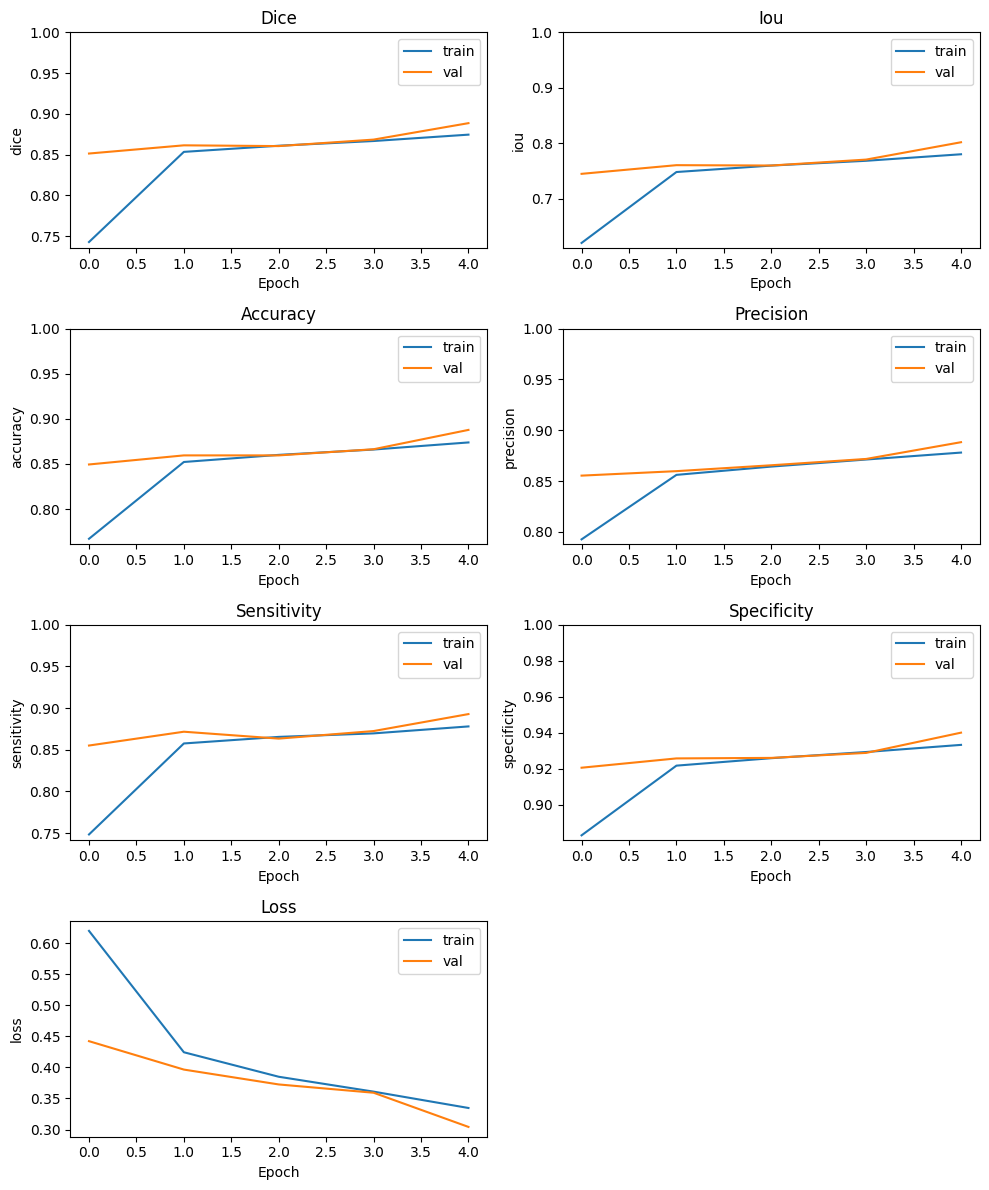

In [25]:
# Plot metrics
fig, ax = plt.subplots(4, 2, figsize=(10, 12))
ax = ax.ravel()
for i, metric in enumerate(['dice', 'iou', 'accuracy', 'precision', 'sensitivity', 'specificity', 'loss']):
    ax[i].plot(hist[f'train_{metric}'], label=f'train')
    ax[i].plot(hist[f'val_{metric}'], label=f'val')
    ax[i].set_title(metric[0].upper() + metric[1:])
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel(metric)
    if metric != 'loss':
        ax[i].set_ylim(top=1)
    ax[i].legend()
ax[-1].axis('off')
plt.tight_layout()
plt.show()

In [11]:
def evaluate(model, criterion, device, loader):
    model.eval()
    history = defaultdict(list)
    total = len(loader)
    loop = tqdm(loader, total=total, leave=True, desc='Evaluating')
    mean_metrics = None

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(loop):
            images = images.to(device=device)
            masks = masks.to(device=device)

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, masks.long())

            # performance metrics
            preds = torch.argmax(outputs, dim=1)
            metrics = get_performance_metrics(masks.cpu(), preds.cpu())

            # update history
            history['loss'].append(loss.item())
            for k, v in metrics.items():
                history[k].append(v)

            # show mean metrics after every batch
            mean_metrics = {k: np.mean(v) for k, v in history.items()}
            loop.set_postfix(**mean_metrics)

    return mean_metrics

In [12]:
results = evaluate(unet, criterion, DEVICE, test_loader)

Evaluating: 100%|██████████| 25/25 [00:01<00:00, 12.76it/s, accuracy=0.883, dice=0.885, iou=0.796, loss=0.315, precision=0.886, sensitivity=0.888, specificity=0.938]


In [217]:
batch = next(iter(test_loader))
images, masks = batch
images = images.to(device=DEVICE)
masks = masks.to(device=DEVICE)
outputs = unet(images)
preds = torch.argmax(outputs, dim=1)
images = images.cpu().numpy().transpose(0, 2, 3, 1)
masks = masks.cpu().numpy()
preds = preds.cpu().numpy()

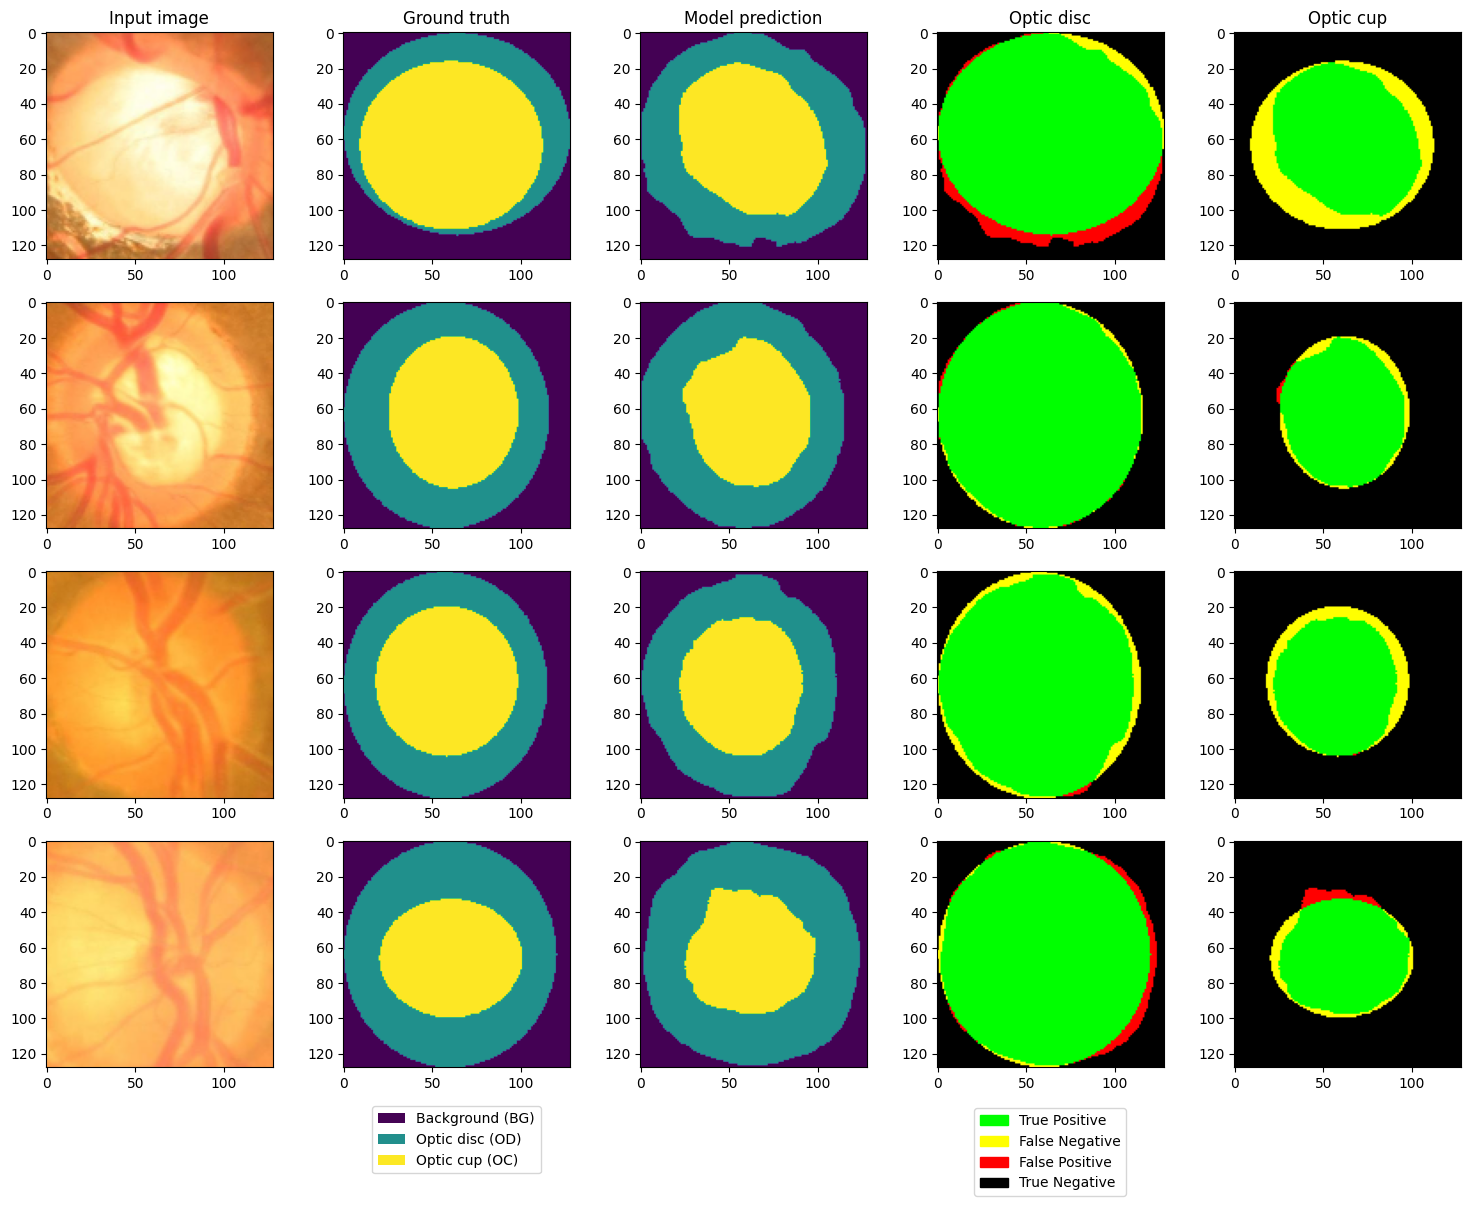

In [306]:
# plot_side_by_side_results(images, masks, preds)
# plot_overlaid_results(images, masks, preds)
# plot_correct_results(images, masks, preds)
plot_results(images, masks, preds)